In [6]:
import pandas as pd
import numpy as np
import sklearn as sk

from sklearn.neighbors import NearestNeighbors


args = {'n_neighbors':100,
        'dist_metric':'cosine',
        'dist_algorithm':'auto',
        'n_jobs':6}

In [2]:
embeddings1 = pd.read_pickle('./data/embeddings/test1.pkl').to_numpy()
embeddings2 = pd.read_pickle('./data/embeddings/test2.pkl').to_numpy()

In [5]:

model = NearestNeighbors(n_neighbors=100,
                         metric='cosine',
                         algorithm='auto',
                         n_jobs=6).fit(embeddings1)
distances, indices = model.kneighbors(embeddings2[:10000])

In [18]:
print(indices)
print(len(indices))

[[     0  90970  72735 ... 149350 125490  40532]
 [     1 112342 142526 ...  83706  82814    150]
 [     2  18576  76443 ...  69714  24141  75321]
 ...
 [  9997  25500  93307 ...  99677 166051 155533]
 [  9998  17892  12030 ...  17429 115118   6034]
 [  9999 174515  55010 ... 175153  26932 144619]]
10000


In [10]:
def det_KNN(embed, args):
    model = NearestNeighbors(n_neighbors=args['n_neighbors'],
                         metric=args['dist_metric'],
                         algorithm=args['dist_algorithm'],
                         n_jobs=args['n_jobs']).fit(embed)
    _, indices = model.kneighbors(embed)
    return indices

def calc_jaccard(set1, set2):
    return len(set1.intersection(set2))/len(set1.union(set2))

def det_similarity(embed1, embed2, args):
    KNN1 = det_KNN(embed1, args)
    # print(KNN1[1:])
    # print(KNN1[0])
    KNN2 = det_KNN(embed2, args)# np.append(KNN1[1:], [KNN1[0]], axis=0) # current hack due to lack of 2nd embedding

    jaccard_scores = [calc_jaccard(set(KNN1[i]), set(KNN2[i])) for i in range(len(KNN1))]
    print(jaccard_scores)
    return jaccard_scores


In [11]:
sim_scores = det_similarity(embeddings1[:10000], embeddings2[:10000], args)

[0.015228426395939087, 0.005025125628140704, 0.010101010101010102, 0.010101010101010102, 0.02564102564102564, 0.015228426395939087, 0.005025125628140704, 0.015228426395939087, 0.010101010101010102, 0.010101010101010102, 0.010101010101010102, 0.010101010101010102, 0.010101010101010102, 0.010101010101010102, 0.005025125628140704, 0.010101010101010102, 0.010101010101010102, 0.005025125628140704, 0.010101010101010102, 0.015228426395939087, 0.005025125628140704, 0.005025125628140704, 0.010101010101010102, 0.005025125628140704, 0.005025125628140704, 0.010101010101010102, 0.005025125628140704, 0.005025125628140704, 0.005025125628140704, 0.010101010101010102, 0.005025125628140704, 0.005025125628140704, 0.015228426395939087, 0.010101010101010102, 0.005025125628140704, 0.010101010101010102, 0.005025125628140704, 0.010101010101010102, 0.010101010101010102, 0.010101010101010102, 0.005025125628140704, 0.005025125628140704, 0.010101010101010102, 0.005025125628140704, 0.005025125628140704, 0.01522842

Text(0.5, 1.0, 'histogram of similarity between the first 10.000 elements of 2 embeddings of the same graph')

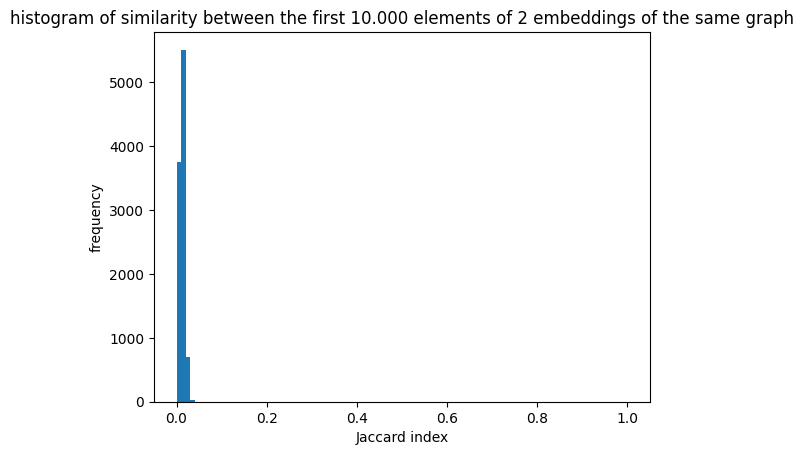

In [14]:
import matplotlib.pyplot as plt

plt.hist(sim_scores, range=[0,1], align='mid', bins=100)
plt.xlabel('Jaccard index')
plt.ylabel('frequency')
plt.title('histogram of similarity between the first 10.000 elements of 2 embeddings of the same graph')